In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.4)
import copy 
import pickle

In [2]:
df = pd.read_csv("data/flights_cleaned_no_outlier_iqr_with_delays.csv")

In [3]:
df.head()

,Unnamed: 0,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,weather_type,passengers,month,combined_delay
0,0,2019-10-02,AA,AA_CODESHARE,AA,5330,OH,5330,10581,BGR,"Bangor, ME",11278,DCA,"Washington, DC",543,535.0,-8.0,11.0,546.0,726.0,5.0,749,731.0,-18.0,N,126.0,116.0,100.0,1.0,590.0,0.0,0.0,0.0,0.0,0.0,Rainy,85523.0,1788.0,0.0
1,3,2019-10-02,AA,AA_CODESHARE,AA,3073,OO,3073,10581,BGR,"Bangor, ME",13930,ORD,"Chicago, IL",1328,1324.0,-4.0,17.0,1341.0,1515.0,14.0,1530,1529.0,-1.0,N,182.0,185.0,154.0,1.0,978.0,0.0,0.0,0.0,0.0,0.0,Rainy,85523.0,1788.0,0.0
2,4,2019-10-02,AA,AA_CODESHARE,AA,4023,MQ,4023,10581,BGR,"Bangor, ME",12953,LGA,"New York, NY",1449,1449.0,0.0,13.0,1502.0,1612.0,2.0,1629,1614.0,-15.0,N,100.0,85.0,70.0,1.0,378.0,0.0,0.0,0.0,0.0,0.0,Rainy,85523.0,1788.0,0.0
3,5,2019-10-02,G4,G4,G4,2119,G4,2119,10581,BGR,"Bangor, ME",14761,SFB,"Sanford, FL",1301,1308.0,7.0,7.0,1315.0,1554.0,5.0,1623,1559.0,-24.0,N,202.0,171.0,159.0,1.0,1299.0,0.0,0.0,0.0,0.0,0.0,Rainy,85523.0,1788.0,0.0
4,7,2019-10-02,AA,AA_CODESHARE,AA,4730,PT,4730,10581,BGR,"Bangor, ME",14100,PHL,"Philadelphia, PA",1001,951.0,-10.0,9.0,1000.0,1127.0,7.0,1149,1134.0,-15.0,N,108.0,103.0,87.0,1.0,473.0,0.0,0.0,0.0,0.0,0.0,Rainy,85523.0,1788.0,0.0


# Prepare data for feature selection

# Feature selection

In [4]:
# https://scikit-learn.org/stable/modules/feature_selection.html

In [5]:
## After testing, found most suitable columns and will remap for final modelling

In [6]:
very_important_columns = [ # ran with what the test data can do
    'fl_date', # get month and bin
#     'op_unique_carrier', # most extensive name list
#     'origin', # need 'origin' to merge weather but already merged! ;)
#     'dest_airport_id', # not sure about this one
    'crs_dep_time', # bin times
#     'dep_time', # only using in TRAIN, to learn how other columns affect this
#     'crs_arr_time',
#     'arr_time', # only using in TRAIN, to learn how other columns affect this
    'weather_type', # add weight values
#     'passengers', # not sure about this one
    'arr_delay' # so we can make a target column...
] # important columns seem to be weather(4), time(bin), month(constant)
'''
According to plots:
Weather weight: Snow=10, Rain=5, Cloudy=2, Sunny=1
Time weight: 0-500 = 1, 501-1000 = 8, 1001-1500 = 10, 1501-2000 = 8, 2001 > = 5
Month weight = Oct = 1, Nov, Jan = 5, Dec = 10
'''

'\nAccording to plots:\nWeather weight: Snow=10, Rain=5, Cloudy=2, Sunny=1\nTime weight: 0-500 = 1, 501-1000 = 8, 1001-1500 = 10, 1501-2000 = 8, 2001 > = 5\nMonth weight = Oct = 1, Nov, Jan = 5, Dec = 10\n'

In [7]:
df_ = df.filter(items=very_important_columns)

In [8]:
df_.head()

,fl_date,crs_dep_time,weather_type,arr_delay
0,2019-10-02,543,Rainy,-18.0
1,2019-10-02,1328,Rainy,-1.0
2,2019-10-02,1449,Rainy,-15.0
3,2019-10-02,1301,Rainy,-24.0
4,2019-10-02,1001,Rainy,-15.0


# remapping crs_dep_time

In [9]:
# Time weight: 0-500 = 1, 501-1000 = 8, 1001-1500 = 10, 1501-2000 = 8, 2001 > = 5
df_.crs_dep_time = df_.crs_dep_time // 100
crs_dep_time_remap = {
    0: 0.10,
    1: 0.10, 
    2: 0.10,
    3: 0.10, 
    4: 0.10,
    5: 0.10, 
    6: 0.80,
    7: 0.80, 
    8: 0.80,
    9: 0.80, 
    10: 0.80,
    11: 1, 
    12: 1,
    13: 1, 
    14: 1,
    15: 1, 
    16: 0.80,
    17: 0.80,
    18: 0.80,
    19: 0.80, 
    20: 0.80,
    21: 0.50, 
    22: 0.50, 
    23: 0.50
}
df_["dep_time_hour_weight"] = df_.crs_dep_time.map(crs_dep_time_remap)

In [10]:
df_.head()

,fl_date,crs_dep_time,weather_type,arr_delay,dep_time_hour_weight
0,2019-10-02,5,Rainy,-18.0,0.1
1,2019-10-02,13,Rainy,-1.0,1.0
2,2019-10-02,14,Rainy,-15.0,1.0
3,2019-10-02,13,Rainy,-24.0,1.0
4,2019-10-02,10,Rainy,-15.0,0.8


In [11]:
df_.isna().sum()

fl_date                 0
crs_dep_time            0
weather_type            0
arr_delay               0
dep_time_hour_weight    0
dtype: int64

In [12]:
df_ = df_.drop(labels="crs_dep_time", axis=1)

# removing month due to low explanitory power

In [13]:
df_["month"] = [ i [5:7] for i in df_.fl_date ]
# change to datetime and get day of week

In [14]:
df_

,fl_date,weather_type,arr_delay,dep_time_hour_weight,month
0,2019-10-02,Rainy,-18.0,0.1,10
1,2019-10-02,Rainy,-1.0,1.0,10
2,2019-10-02,Rainy,-15.0,1.0,10
3,2019-10-02,Rainy,-24.0,1.0,10
4,2019-10-02,Rainy,-15.0,0.8,10
...,...,...,...,...,...
2073110,2019-01-01,Sunny,-10.0,0.8,01
2073111,2019-01-01,Sunny,-30.0,0.8,01
2073112,2019-01-01,Rainy,-11.0,1.0,01
2073113,2019-01-01,Rainy,-19.0,0.8,01


In [15]:
# don't drop next time
df_ = df_.drop(labels="fl_date", axis=1)


In [16]:
df_.head()

,weather_type,arr_delay,dep_time_hour_weight,month
0,Rainy,-18.0,0.1,10
1,Rainy,-1.0,1.0,10
2,Rainy,-15.0,1.0,10
3,Rainy,-24.0,1.0,10
4,Rainy,-15.0,0.8,10


In [17]:
df_.isna().sum()

weather_type            0
arr_delay               0
dep_time_hour_weight    0
month                   0
dtype: int64

In [18]:
# df_.month.unique()

In [19]:
# # Month weight = Oct = 1, Nov, Jan = 5, Dec = 10
# month_remap = { 
#     '10': 0.10,
#     '11': 0.50, 
#     '12': 1,
#     '01': 0.50
# }
# df_["month_weight"] = df_.month.map(month_remap)

In [20]:
df_.head()

,weather_type,arr_delay,dep_time_hour_weight,month
0,Rainy,-18.0,0.1,10
1,Rainy,-1.0,1.0,10
2,Rainy,-15.0,1.0,10
3,Rainy,-24.0,1.0,10
4,Rainy,-15.0,0.8,10


# remapping weather

In [21]:
# df_['weather_weight'] = df['weather_type'] 

In [22]:
df_.weather_type.unique()

array(['Rainy', 'Sunny', 'Snowy', 'Cloudy'], dtype=object)

In [23]:
df_.head()

,weather_type,arr_delay,dep_time_hour_weight,month
0,Rainy,-18.0,0.1,10
1,Rainy,-1.0,1.0,10
2,Rainy,-15.0,1.0,10
3,Rainy,-24.0,1.0,10
4,Rainy,-15.0,0.8,10


In [24]:
df_ = pd.get_dummies(df_, columns=['weather_type'], drop_first=False)

In [25]:
#trying to add back weather to help increase r^2


In [26]:
# # # Weather weight: Snow=10, Rain=5, Cloudy=2, Sunny=1
# weather_remap = {
#     "Rainy": 0.50,
#     "Sunny": 0.10, 
#     "Snowy": 1,
#     "Cloudy": 0.20
# }
# df_.weather_weight = df_.weather_weight.map(weather_remap)

In [27]:
df_.head()

,arr_delay,dep_time_hour_weight,month,weather_type_Cloudy,weather_type_Rainy,weather_type_Snowy,weather_type_Sunny
0,-18.0,0.1,10,0,1,0,0
1,-1.0,1.0,10,0,1,0,0
2,-15.0,1.0,10,0,1,0,0
3,-24.0,1.0,10,0,1,0,0
4,-15.0,0.8,10,0,1,0,0


In [28]:
df_.isna().sum()

arr_delay               0
dep_time_hour_weight    0
month                   0
weather_type_Cloudy     0
weather_type_Rainy      0
weather_type_Snowy      0
weather_type_Sunny      0
dtype: int64

In [29]:
# # Used dummies before, got 0.03 to 0.06 results. Trying feature selection/engineering next.
# df_dummies = pd.get_dummies(df_, columns=['weather_type'])
# df_dummies = pd.get_dummies(df_dummies, columns=['op_unique_carrier'])
# df_dummies = pd.get_dummies(df_dummies, columns=['origin'])

In [30]:
df_.head()

,arr_delay,dep_time_hour_weight,month,weather_type_Cloudy,weather_type_Rainy,weather_type_Snowy,weather_type_Sunny
0,-18.0,0.1,10,0,1,0,0
1,-1.0,1.0,10,0,1,0,0
2,-15.0,1.0,10,0,1,0,0
3,-24.0,1.0,10,0,1,0,0
4,-15.0,0.8,10,0,1,0,0


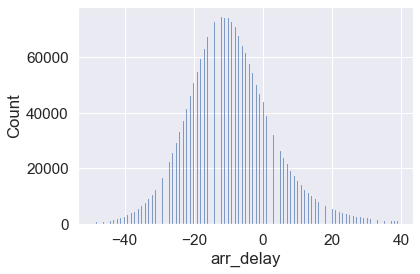

In [31]:
sns.histplot(df_.arr_delay);

# Smote and balance

In [32]:
df_checkpoint = df_.copy()
df_checkpoint = df_checkpoint.sample(frac=0.25)

In [33]:
X = df_checkpoint[df_checkpoint.columns.difference(['arr_delay'])]
y = df_checkpoint["arr_delay"]

In [34]:
print(X.shape)
print(y.shape)

(518279, 6)
(518279,)


In [35]:
y = pd.DataFrame(y)

In [36]:
y[y < 0] = 0

In [37]:
y.shape

(518279, 1)

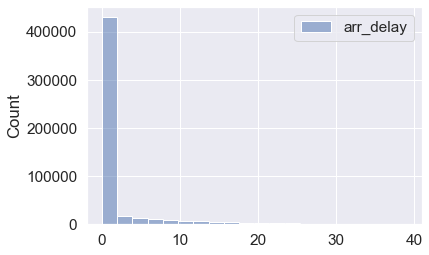

In [38]:
sns.histplot(y); # super imbalanced.

In [39]:
# check version number
import imblearn
# transform the dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [40]:
print(X.shape)
print(y.shape)

(16804400, 6)
(16804400, 1)


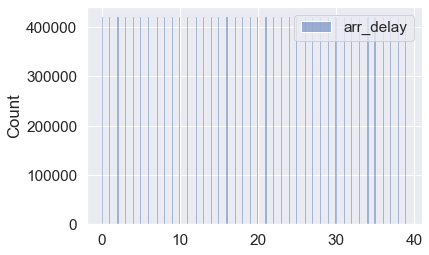

In [41]:
sns.histplot(y);

## 16 MILLION ROWS but balanced.

In [42]:
y.arr_delay

0            0.0
1            0.0
2            1.0
3            0.0
4           10.0
            ... 
16804395    39.0
16804396    39.0
16804397    39.0
16804398    39.0
16804399    39.0
Name: arr_delay, Length: 16804400, dtype: float64

In [43]:
# remerge y to X... sample frac... resplit.
X["arr_delay"] = y.arr_delay
X_checkpoint = X.copy()
X_checkpoint = X_checkpoint.sample(frac=0.15)

In [44]:
X = X_checkpoint[X_checkpoint.columns.difference(['arr_delay'])]
y = X_checkpoint["arr_delay"]

In [45]:
y = pd.DataFrame(y)

In [46]:
print(X.shape)
print(y.shape)

(2520660, 6)
(2520660, 1)


## Main Task: Regression Problem
The target variable is ARR_DELAY. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.
For example, variables CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.
We will be evaluating your models by predicting the ARR_DELAY for all flights 1 week in advance.

#### linear / logistic / multinomial logistic regression
#### Naive Bayes
#### Random Forest
#### SVM
#### XGBoost
#### The ensemble of your own choice

In [47]:
# X = X.replace([np.inf, -np.inf], np.nan)
# X = X.dropna()

In [48]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.75,random_state=42)

In [49]:
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute
from numpy import mean
from numpy import std

## Naive Bayes Model

In [50]:
# 0.0361 score
from sklearn import naive_bayes
gnb = naive_bayes.GaussianNB()
gnb.fit(X_train, y_train.values.ravel())
y_pred = gnb.predict(X_test)
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

# save the model to disk
filename = 'finalized_Naive_Bayes.sav'
pickle.dump(gnb, open(filename, 'wb'))

0.03211857212000032


## Lasso (not good)

In [51]:
# 0.060 score unscaled: scaled data 0.041: after trimming huge 0.034
model = Lasso(alpha=0.5)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 9.917 (0.012)


## Random Forest Classifier Model

In [52]:
# 0.036 score unscaled: scaled same
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=3, random_state=42, n_jobs=-1)
#added ravel
clf = clf.fit(X_train, y_train.values.ravel())

y_pred = clf.predict(X_test)

# 0.03 score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

# save the model to disk
filename = 'finalized_Random_forest.sav'
pickle.dump(clf, open(filename, 'wb'))

0.03852165702633437


Confusion Matrix


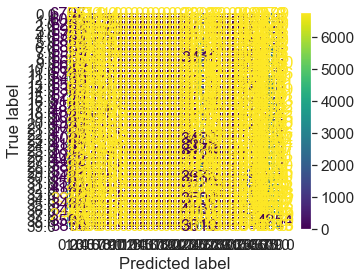

In [53]:
from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

print("Confusion Matrix")
plot_confusion_matrix(clf, X_test, y_test)

## Gridsearch cells. Do not run.

In [54]:
# # parameter grid
# parameter_candidates = {
#     'n_estimators':[270, 285, 300],
#     'max_depth':[3]
# }
# from sklearn import datasets, svm
# from sklearn.model_selection import GridSearchCV
# grid_result = GridSearchCV(clf, param_grid=parameter_candidates, n_jobs=-1)
# the_fit = grid_result.fit(X_train, y_train.values.ravel())
# bestresult = grid_result.best_estimator_

In [55]:
# # View the accuracy score best run: MD3, nest300 score:0.04
# print('Best score for data1:', grid_result.best_score_) 
# print(grid_result.best_params_)
# print(bestresult)
# grid_result.score(X_train, y_train)

## Random Forest tuned

In [56]:
# 0.036 score unscaled frac=0.25 : scaled full data score SAME 0.036
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=3, n_estimators=285, random_state=42, n_jobs=-1)
clf = clf.fit(X_train, y_train.values.ravel())

y_pred = clf.predict(X_test)

#  score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)
print(y_test)
print(y_pred)

0.03819951917354979
          arr_delay
1148026         2.0
2544866         5.0
3628698         8.0
2121521         4.0
2808910         6.0
...             ...
6629024        15.0
10298967       24.0
284048          0.0
15754682       37.0
16662015       39.0

[630165 rows x 1 columns]
[25. 25. 24. ... 24. 38.  0.]


## Linear/Log Regression

In [57]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_train, y_train))

# save the model to disk
filename = 'finalized_LinReg.sav'
pickle.dump(reg, open(filename, 'wb'))

0.03672276844253597


In [58]:
reg.coef_

array([[  1.1187395 ,  -0.01722113, -16.35216748, -15.39826713,
        -10.81433199, -17.14331208]])

In [59]:
reg.intercept_

array([34.12596605])

## Decision Tree

In [60]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn import metrics
clf_dt = DecisionTreeClassifier()
model = clf_dt.fit(X_train,y_train)
y_pred = clf_dt.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# save the model to disk
filename = 'finalized_Decision_Tree.sav'
pickle.dump(clf_dt, open(filename, 'wb'))

Accuracy: 0.04540556838288385


In [61]:
# How do I visualize a tree?
text_representation = tree.export_text(clf_dt)
print(text_representation)



|--- feature_4 <= 0.50
|   |--- feature_0 <= 0.50
|   |   |--- feature_0 <= 0.50
|   |   |   |--- feature_0 <= 0.10
|   |   |   |   |--- feature_1 <= 11.50
|   |   |   |   |   |--- feature_3 <= 0.50
|   |   |   |   |   |   |--- feature_1 <= 5.50
|   |   |   |   |   |   |   |--- feature_5 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_2 <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 29.0
|   |   |   |   |   |   |   |   |--- feature_2 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 9.0
|   |   |   |   |   |   |   |--- feature_5 >  0.50
|   |   |   |   |   |   |   |   |--- class: 33.0
|   |   |   |   |   |   |--- feature_1 >  5.50
|   |   |   |   |   |   |   |--- feature_1 <= 10.50
|   |   |   |   |   |   |   |   |--- feature_2 <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- feature_2 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- feature_1 >  10.50
|   |   |   |   |   |  

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_dt, 
                   # feature_names=df_.feature_names,  
                   # class_names=df_.target_names,
                   filled=True)
fig.savefig("decistion_tree.png")


## SVM (do not run)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import Normalizer
# scaler = StandardScaler()
# scaler.fit(df_checkpoint)
# X = scaler.transform(df_checkpoint.loc[:, df_checkpoint.columns != 'arr_delay'])
# X = df_checkpoint[df_checkpoint.columns.difference(['arr_delay'])]
# y = df_checkpoint["arr_delay"]

In [ ]:
# from sklearn import svm
# clf = svm.SVC(kernel='poly')
# clf.fit(X_train, y_train.values.ravel())
# y_pred = clf.predict(X_test)

In [ ]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred)

In [ ]:
# clf2 = svm.SVC(kernel='rbf')
# clf2.fit(X_train, y_train.values.ravel())
# y_pred2 = clf2.predict(X_test)

In [ ]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred2)

In [ ]:
# clf3 = svm.SVC(kernel='sigmoid')
# clf3.fit(X_train, y_train.values.ravel())
# y_pred3 = clf3.predict(X_test)

In [ ]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred3)

In [ ]:
# from sklearn import metrics
# print("Accuracy poly:",metrics.accuracy_score(y_test, y_pred))
# print("Accuracy rbg:",metrics.accuracy_score(y_test, y_pred2))
# print("Accuracy sigmoid:",metrics.accuracy_score(y_test, y_pred3))

## XGBoost

In [ ]:
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# data_dmatrix = xgb.DMatrix(data=X, label=y)
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', # not XGBClassifier() bc regression.
#                           colsample_bytree = 0.3, 
#                           learning_rate = 0.1,
#                           max_depth = 3, 
#                           alpha = 10, 
#                           n_estimators = 250)

In [ ]:
# Import Test Dataset, clean/merge, export with y column to CSV for submission